In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import (
    make_gap_data,
    make_gap_plot,
)

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])
df = pyam.IamDataFrame(paper_data)
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 914 out of 1871 scenarios


In [4]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [5]:
kyoto_gases_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases'

# Figure 2A

In [6]:
variables = [
    kyoto_gases_variable,
]
quantiles = (0.1, 0.25, 0.5, 0.75, 0.9)
year_start, year_end = 2010, 2100

data = pyam.concat([
    (
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Category=category)
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .compute.quantiles(quantiles)
        .rename(model={'Quantiles': temp})
    ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
])

for variable in variables:
    data.append(
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .compute.quantiles(quantiles)
        .rename(model={'Quantiles': 'Current Policies'}),
        inplace=True
    )

In [7]:
# taken from p17, row 'Global emissions, including the impact of overachievement of NDCs *' of den Elzen 2022 SI
targets = pd.DataFrame([
    ('Current Policies (den Elzen 2022, adj.)', 56.826, 52.592, 59.552, 'dimgrey', 0),
    ('Conditional NDCs (den Elzen 2022, adj.)', 50.700, 48.542, 52.202, 'plum', -0.35),
    ('Unconditional NDCs (den Elzen 2022, adj.)', 52.284, 50.059, 54.136, 'thistle', 0.35),
], columns=['label', 'med', 'min', 'max', 'color', 'jitter'])

target_2015_value = 51.181 # to adjust for differences in LULUCF definitions, we take an offset of values used in den Elzen per conversations with Niklas Forsell
this_study_2015_value = (
    data
    .filter(variable=kyoto_gases_variable, year=2015, scenario='0.5')
    .timeseries()
    .mean()
    .iloc[0]
)
target_offset = target_2015_value - this_study_2015_value
target_2015_value, this_study_2015_value, target_offset

(51.181, 50.875938917628766, 0.30506108237123186)

In [8]:
color_map = {
    'Current Policies': pyam.plotting.PYAM_COLORS["AR6-IP-CurPol"],
    '2C': pyam.plotting.PYAM_COLORS["AR6-C1"],
    '1.5C': pyam.plotting.PYAM_COLORS["AR6-C3"], 
}
rc = pyam.run_control()
#rc.store['color']['model'] = {}
rc.update({'color': {'model': color_map}})

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


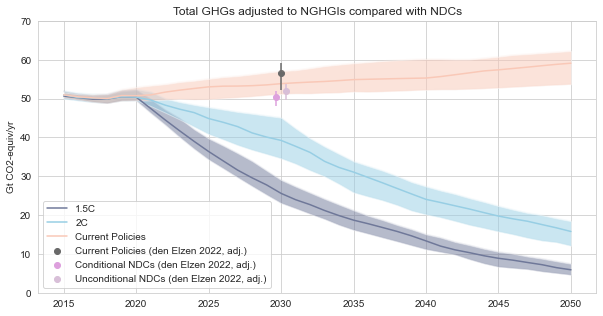

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between={'alpha': 0.5}, ax=ax, alpha=0.1)
)
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2051))
    .filter(scenario='0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')
ax.set_ylim(0, 70)

fig.savefig('./files/fig3a.pdf', bbox_inches='tight')
fig.savefig('./files/fig3a.jpg', bbox_inches='tight')

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


(-10.0, 80.0)

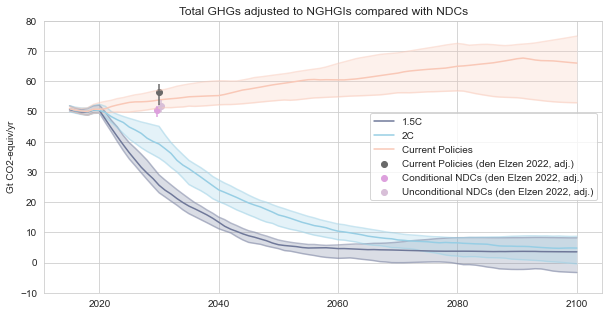

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2101))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, alpha=0.5)
)
(
    data
    .filter(variable=kyoto_gases_variable, year=range(2015, 2101))
    .filter(scenario='0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')
ax.set_ylim(-10, 80)

## Gap quantification

In [11]:
med_target = targets.set_index('label')['med'] - target_offset
med_target

label
Current Policies (den Elzen 2022, adj.)      56.520939
Conditional NDCs (den Elzen 2022, adj.)      50.394939
Unconditional NDCs (den Elzen 2022, adj.)    51.978939
Name: med, dtype: float64

In [12]:
pathways = (
    data
    .filter(variable=kyoto_gases_variable, year=2030, scenario=['*0.5*'])
    .timeseries()
    [2030]
    .unstack('model')
    .reset_index(drop=True)
)
pathways

model,1.5C,2C,Current Policies
0,25.603602,39.248306,53.865272


In [13]:
gap = pd.DataFrame({c: med_target - float(pathways[c]) for c in pathways})
gap.loc[-2:, 'Current Policies'] = np.nan
gap

C:\Users\gidden\AppData\Local\Temp\ipykernel_31344\2323131857.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  gap.loc[-2:, 'Current Policies'] = np.nan


,1.5C,2C,Current Policies
label,,,
"Current Policies (den Elzen 2022, adj.)",30.917337,17.272633,2.655667
"Conditional NDCs (den Elzen 2022, adj.)",24.791337,11.146633,NaN
"Unconditional NDCs (den Elzen 2022, adj.)",26.375337,12.730633,NaN


In [14]:
# values in 2030
estimates_den_elzen = {
    '2C': 41.5, # 66% chance
    '1.5C': 24.7,
}
for key, value in estimates_den_elzen.items():
    gap[f'{key} (den Elzen 2022, adj.)'] = med_target - (value - target_offset)

In [15]:
gap

,1.5C,2C,Current Policies,"2C (den Elzen 2022, adj.)","1.5C (den Elzen 2022, adj.)"
label,,,,,
"Current Policies (den Elzen 2022, adj.)",30.917337,17.272633,2.655667,15.326,32.126
"Conditional NDCs (den Elzen 2022, adj.)",24.791337,11.146633,NaN,9.200,26.000
"Unconditional NDCs (den Elzen 2022, adj.)",26.375337,12.730633,NaN,10.784,27.584


In [34]:
gap.columns

Index(['1.5C', '2C', 'Current Policies', '2C (den Elzen 2022, adj.)',
       '1.5C (den Elzen 2022, adj.)'],
      dtype='object')

In [37]:
gap = gap.rename(columns= {
    '1.5C': '1.5C (this study)',
    '2C': '2C (this study)',
})

Text(0.5, 1.0, 'Emission gap between targets, current policies, and pledges')

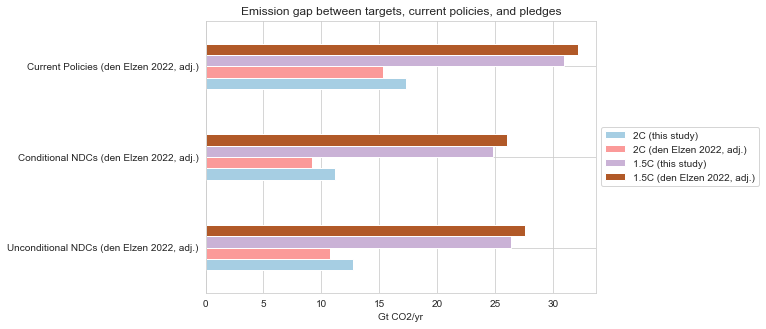

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))
order = ['2C (this study)', '2C (den Elzen 2022, adj.)', '1.5C (this study)', '1.5C (den Elzen 2022, adj.)']
gap[order].loc[gap.index[::-1]].plot.barh(cmap='Paired', ax=ax)
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])
ax.set_ylabel('')
ax.set_xlabel('Gt CO2/yr')
ax.set_title('Emission gap between targets, current policies, and pledges')

In [18]:
(12.7 - 10.8) / 10.8 # 2C

0.1759259259259258

In [19]:
(26.4 - 27.6) / 27.6

-0.04347826086956532

# Figure 2B

In [20]:
# change in emissions in negative, gap is positive
adj = -1 * make_gap_data(df, 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020', categories_to_temp)
orig = -1 * make_gap_data(df, 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020', categories_to_temp)

Text(0.5, 1.0, 'Change in 2030 regional emission reductions between \npathways with and without the NGHGI correction')

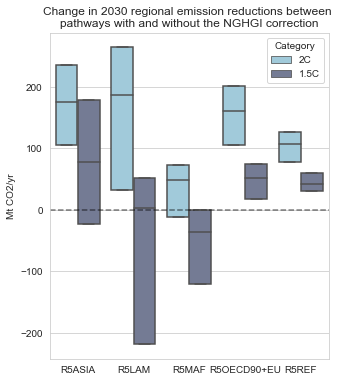

In [25]:
fig, ax = plt.subplots(figsize=(5, 6))

make_gap_plot(adj-orig, drop={'region': 'World'}, ax=ax, palette=color_map)
ax.set_xlabel('')
ax.set_ylabel('Mt CO2/yr')
ax.set_title(
    'Change in 2030 regional emission reductions between \n'
    'pathways with and without the NGHGI correction'
)

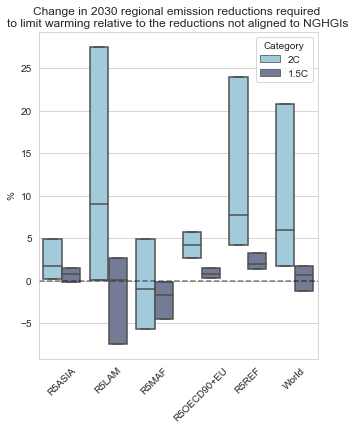

In [27]:
fig, ax = plt.subplots(figsize=(5, 6))

make_gap_plot(100 * ((adj / orig) - 1), ax=ax, palette=color_map)
ax.set_xlabel('')
ax.set_ylabel('%')

ax.set_title(
    'Change in 2030 regional emission reductions required \n'
    'to limit warming relative to the reductions not aligned to NGHGIs'
)
plt.xticks(rotation=45)

fig.savefig('./files/fig3b.pdf', bbox_inches='tight')